## MTH9878 Interest Rate Models HW4
* Group 05
* Author: Pan, Hongchao & Zhang, Chendi
* Kernel version: Python 2.7
* Packages: pandas, numpy, matplotlib, scipy, numba
* Data: Given SwaptionVolData data
* Notes:
    * The notes and steps to deduce formulas had been put at corresponding cells.
    * The close formula of ATM SABR implied lognormal vol came from the original SABR model. The comparison of notations had been put in the Markdown.
    * The deduction of close formula of ATM SABR implied normal vol by using l’Hopital’s rule had been put in the Markdown

In [1]:
# load packages/features from version 3.x
from __future__ import absolute_import, print_function, division
# load packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize # SABR calibration
import matplotlib.ticker as ticker

### Q1: Implement normal and lognormal model

* Normal model by using forward price


* $N(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^x e^{-\frac{z^2}{2}}dz$


* $N'(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$

In [2]:
# Discount factor function
def disf(r,t,T):
    '''
    :param r: interest rate
    :param t: starting date
    :param T: end date
    '''
#    return math.exp(-r*(T-t))
    return 1  # All discount factor is 1 in Q1-4

def Normal_forward(r,t,T,K,F0,vol,opt_type=None):
    '''
    :param r: interest rate, 0 in this question
    :param t: start date
    :param T: maturity data
    :param K: strike
    :param F0: forward price at time t
    :param vol: volatility
    :param opt_type: indicator of call or put option
    return: option price
    '''
    # Compute d1 and d2 in normal model
    # Reference: formula (25) in lecture notes 3
    d1=(F0-K)/(vol*math.sqrt(T-t))
    d2=-d1
    
    disc=disf(r,t,T)
    
    call_price=disc*vol*math.sqrt(T-t)*(d1*norm.cdf(d1)+
                                                    math.exp(-0.5*d1*d1)/math.sqrt(2*np.pi))
    put_price=disc*vol*math.sqrt(T-t)*(d2*norm.cdf(d2)+
                                                   math.exp(-0.5*d2*d2)/math.sqrt(2*np.pi))
    
    if(opt_type is None):
        print("Normal model: No option type indicated, assuming CALL.")
        return call_price
    if (opt_type.upper()=="CALL"):
        return call_price
    if(opt_type.upper()=="PUT"):
        return put_price
    else:
        print("Option type is invaild.")
        return -1

* Lognormal model - BS model by using forward price

In [3]:
def BS_forward(r,t,T,K,F0,vol,opt_type=None):
    '''
    :param r: interest rate, 0 in this question
    :param t: start date
    :param T: maturity data
    :param K: strike
    :param F0: forward price at time t
    :param vol: volatility
    :param opt_type: indicator of call or put option
    return: option price
    '''
    # Reference: formula (6) in lecture notes 3 and
    # https://github.com/hongchaopan/Baruch_AC/blob/master/black_scholes.py
    d1=(np.log(F0/K)+(0.5*vol*vol)*(T-t))/(vol*math.sqrt(T-t))
    d2=d1-vol*math.sqrt(T-t)
    
    disc=disf(r,t,T)
    
    call_price=disc*(F0*norm.cdf(d1)-K*norm.cdf(d2))
    put_price=disc*(K*norm.cdf(-d2)-F0*norm.cdf(-d1))
    
    if(opt_type is None):
        print("Normal model: No option type indicated, assuming CALL.")
        return call_price
    if (opt_type.upper()=="CALL"):
        return call_price
    if(opt_type.upper()=="PUT"):
        return put_price
    else:
        print("Option type is invaild.")
        return -1

* **Test normal and Lognormal model**

In [4]:
# Set up parameters
# Since the Q1-Q4 assumed the discount factors =1, 
# r should be 0 and assume q=0 (no dividend)
r=0
t=0
T=2
F0=0.8
K=F0+20/10000 # ATM+20basis point
vol=0.4
option=["CALL","PUT"]
# Compute the option prices
prices=[]
prices.append(Normal_forward(r,t,T,K,F0,vol,option[0]))
prices.append(Normal_forward(r,t,T,K,F0,vol,option[1]))
prices.append(BS_forward(r,t,T,K,F0,vol,option[0]))
prices.append(BS_forward(r,t,T,K,F0,vol,option[1]))

* Check the results

* BS formula using stock price
$$
P^{\text{call}}=S_0^{-q(T-t)}N(d_1)-Ke^{-r(T-t)}N(d_2)\\
P^{\text{put}}=Ke^{-r(T-t)}N(-d_2)-S_0^{-q(T-t)}N(-d_1)
$$
with
$$
d_1=\frac{log\left(\frac{S_0}{K}\right)+\left(r-q+\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}}\\
d_2=d_1-\sigma\sqrt{T-t}
$$
Therefore, if r=q=0, changing $S_0$ to $F_0$, we will get BS formula using forward price. Thus, we can us BS online calculator to verify BS price.


* BS online calculator: http://www.math.drexel.edu/~pg/fin/VanillaCalculator.html

In [5]:
print("The call price from Normal model is: ", '{:.9f}'.format(prices[0]))
print("The call price from Lognormal model is: ",'{:.9f}'.format(prices[2]))
print("The put price from Normal model is: ",'{:.9f}'.format(prices[1]))
print("The put price from Lognormal model is: ",'{:.9f}'.format(prices[3]))

The call price from Normal model is:  0.224677244
The call price from Lognormal model is:  0.177386466
The put price from Normal model is:  0.226677244
The put price from Lognormal model is:  0.179386466


### Q2: Convert lognormal implied vol to normal implied vol

* Define functions to compute lognormal implied vol

* Set $f(\sigma)=P_{ln}-P_M$, where $P_M$ is market price
$\Rightarrow$
$$
\frac{df}{d\sigma}=\frac{P_{ln}}{d\sigma}=\text{Vega}_{ln}
$$


* $$P_{ln}=e^{-r(T-t)}[F_0N(d_1)-KN(d_2)]$$
with 
$$
d_{1,2}=\frac{log(\frac{F_0}{K})\pm \frac{\sigma^2}{2}(T-t)}{\sigma\sqrt{(T-t)}}
$$
$\Rightarrow$
$$
\text{Vega}_{ln}=e^{-r(T-t)}[F_0N'(d_1)\frac{dd_1}{d\sigma}-KN'(d_2)\frac{dd_2}{d\sigma}]
$$
with
$$
N'(x)=\frac{1}{\sqrt{2\pi}}e^{\frac{-x^2}{2}}\\
\frac{dd_1}{d\sigma}=\frac{log(\frac{F_0}{K})}{\sqrt{(T-t)}}\left(-\frac{1}{\sigma^2}\right)+\frac{\sqrt{(T-t)}}{2}\\
\frac{dd_2}{d\sigma}=\frac{log(\frac{F_0}{K})}{\sqrt{(T-t)}}\left(-\frac{1}{\sigma^2}\right)-\frac{\sqrt{(T-t)}}{2}
$$

* Define function to compute Vega

In [6]:
# Define a function to compute N'(x)

def N_prime(x):
    return math.exp(-0.5*x*x)/math.sqrt(2*np.pi)

def Vega_forward(r,t,T,K,F0,vol):
    '''
    :param r: interest rate, 0 in this question
    :param t: start date
    :param T: maturity data
    :param K: strike
    :param F0: forward price at time t
    No option type needed, since Vega for BS put and BS call are the same
    return: Vega in BS formed by forward price
    '''
    d1=(np.log(F0/K)+(0.5*vol*vol)*(T-t))/(vol*math.sqrt(T-t))
    d2=d1-vol*math.sqrt(T-t)    
    
    d1_prime=-np.log(F0/K)/(math.sqrt(T-t)*vol*vol)+math.sqrt(T-t)/2
    d2_prime=d1_prime-math.sqrt(T-t)
    
    disc=disf(r,t,T)
    
    return disc*(F0*N_prime(d1)*d1_prime-K*N_prime(d2)*d2_prime)
    

In [7]:
def imp_vol_BS_forward(r,t,T,K,F0,P,tol,opt_type=None):
    '''
    :param r: interest rate, 0 in this question
    :param t: start date
    :param T: maturity data
    :param K: strike
    :param F0: forward price at time t
    :param P: market price
    :param opt_type: indicator of call or put option
    :param tol: tolerence for declaring convergence of Newtown's method
    return: implied lognormal volatility
    '''
    x0=0.25 # Initial guess: 25% volatility
    x_new=x0
    x_old=x0-1
    # f_x and f_prime is given here

    while abs(x_new-x_old)>tol:
        x_old=x_new
        V_BS=BS_forward(r,t,T,K,F0,x_new,opt_type)
        V_vega=Vega_forward(r,t,T,K,F0,x_new)
        x_new=x_new-(V_BS-P)/V_vega

    return x_new

In [8]:
# Compute lognormal volatility
# Use parameters in Q1
r=0
t=0
T_ln=2
F0_ln=0.8
K=F0_ln+20/10000 # ATM+20basis point
#vol=0.4
option=["CALL","PUT"]
# Market Put price
P_m=0.3
# Market Call price
C_m=0.1
sigma_ln_C=imp_vol_BS_forward(r,t,T_ln,K,F0_ln,C_m,tol=1e-6,opt_type=option[0])
sigma_ln_P=imp_vol_BS_forward(r,t,T_ln,K,F0_ln,P_m,tol=1e-6,opt_type=option[1])
print("The implied lognormal volatility computed by given Call option is: ",
      '{:.6f}'.format(sigma_ln_C))
print("The implied lognormal volatility computed by given Put option is: ",
      '{:.6f}'.format(sigma_ln_P))

The implied lognormal volatility computed by given Call option is:  0.224424
The implied lognormal volatility computed by given Put option is:  0.687805


* Convert implied lognormal volatility to normal implied volatility based on formula of Q2(a) in HW3

* The formula is given as:
$$
\sigma_n=\sqrt{\frac{2\pi}{T}}F_0\text{erf} \left(\frac{\sqrt{T}}{2\sqrt{2}}\sigma_{ln}\right)
$$
with
$$
\text{erf}(x)=\frac{2}{\sqrt{\pi}}\int_0^xe^{-u^2}du
$$

* Define the error function by using Simpson's rule

* Reference: https://github.com/hongchaopan/Baruch_AC/blob/master/Numerical_integration_methods.py

In [9]:
def f_x(x):
    '''
    Function in the integration part
    '''
    return math.exp(-x*x)

# Simpson's rule
def simpson_rule(a,b,f,n):
    '''
    :param a: left endpoint
    :param b: right endpoint
    :param f: to be integrated function
    :param n: number of partition intervals
    '''
    h= (b-a)/n
    result=(f(a) + f(b))/6

    for i in range(1, n):
        result += f(a + i*h)/3
    for i in range(1, n+1):
        result += 2*f(a + (i-0.5)*h)/3

    return result*h

# Convergence
def approx_val_tol(f_med,a,b,f,n,tol):
    '''
    :param f_med: approximation method: mid_point/Trapezoidal/Simpson's rule
    :param a: left endpoint
    :param b: right endpoint
    :param f: to be integrated function
    :param n: starting number of partition intervals
    :param tol: tolerence for declaring convergence
    '''
    #tol=5e-7
    result_old=f_med(a,b,f,n)
    n=2*n # Using doubling strategy
    result_new=f_med(a,b,f,n)

    while(abs(result_old-result_new)>tol):
        result_old=result_new
        n=2*n
        result_new=f_med(a,b,f,n)

    return result_new

# erf function

def erf(a,b,f,n,tol):
    '''
    :param a: left endpoint
    :param b: right endpoint
    :param f: to be integrated function
    :param n: starting number of partition intervals
    :param tol: tolerence for declaring convergence
    '''
    return approx_val_tol(simpson_rule,a,b,f,n,tol)

In [10]:
# Compute erf
a=0
b=math.sqrt(T_ln)*sigma_ln_C/(2*math.sqrt(2))
n=4 # Starting intervals
tol=1e-9
erf_ln=erf(a,b,f_x,n,tol)
print("The value of erf is: ",'{:.9f}'.format(erf_ln))

The value of erf is:  0.111743037


* Convert the implied lognormal volatility to implied normal volatility

In [11]:
sigma_n=math.sqrt(2*np.pi/T_ln)*F0_ln*erf_ln
print("The implied normal volatility converted from implied lognormal volatility is: ",
      '{:.6f}'.format(sigma_n))

The implied normal volatility converted from implied lognormal volatility is:  0.158448


### Q3: Implement SABR implied normal volatility

* Reference: Use formula (14) approximately SABR implied normal volatility in Lecture notes 4 to avoid $O(\epsilon)$ in formula (13) and SABR item in Wikipedia: https://en.wikipedia.org/wiki/SABR_volatility_model


* $$C(F_{mid})=F_{mid}^{\beta}$$
$\Rightarrow$
$$
\frac{C'(F_{mid})}{C(F_{mid})}=\frac{\beta}{F_{mid}}\\
\frac{C''(F_{mid})}{C(F_{mid})}=\frac{-\beta(1-\beta)}{F_{mid}^2}
$$


* $$\epsilon=T\alpha^2<<1$$


* Also include SABR implied lognormal volatility


* For ATM SABR implied vol, used formula in the original paper introducing the SABR model by Andrew. However the notations are slightly different than what we used in the class. The comparison of notations is showing below:

**Original Paper** | **Our class**
----- | -----
$\nu$|$\alpha$
$\alpha$|$\sigma$
$\beta$|$\beta$
$\rho$|$\rho$

* Original paper introducing the SABR model: http://www.javaquant.net/papers/managing_smile_risk.pdf


* Boundary conditions for SABR model with our class's notation is:

$$\sigma>0, 0<\beta<1, -1<\rho<1, \alpha>0$$


* For ATM SABR normal implied vol, we have two approaches:
    * Convert ATM SABR lognormal vol to normal vol by using erf function
    * By using l’Hopital’s rule
    $$
    \frac{dD(\xi)}{dK}=\frac{dD(\xi)}{d\xi}\frac{d\xi}{dK}=\frac{-\alpha K^{-\beta}}{\sigma_0\sqrt{1-2\rho\xi+\xi^2}}
    $$
    $\Rightarrow$
    $$
    \left(\frac{F0-K}{D(\xi)}\right)'_K=\frac{\sigma_0K^{\beta}}{\alpha }
    $$
    since $K\rightarrow0$, $\xi\rightarrow0.$
    
    and
    Denote
    $$
    A=\left(1+\left(\frac{2\gamma_2-\gamma_1^2}{24}\left(\frac{\sigma_0 C(F_{mid})}{\alpha}\right)^2+\frac{\rho\gamma_1}{4}\frac{\sigma_0 C(F_{mid})}{\alpha}+\frac{2-3\rho^2}{24}\right)\epsilon\right)\\
    F_{mid}=\frac{F+K}{2}
    $$
    $\Rightarrow$
    $$
    A'_K=\left(\frac{2\beta(1-\beta)^2\sigma^0F_{mid}^{2\beta-3}}{24\alpha^2}+\frac{\rho\sigma_0\beta(\beta-1)F_{mid}^{\beta-2}}{8\alpha}\right)\epsilon
    $$
    Therefore,
    $$
    \sigma_n^{ATM}=\alpha \frac{F0-K}{D(\xi)}A=\sigma_0K^{\beta}A+\alpha \frac{F0-K}{D(\xi)}A'_K
    $$
    
    Since for ATM SBAR normol model, $\sigma_n^{ATM}=\sigma_0K^{\beta}(1+O(\epsilon))+O(h)$, where $O(h)$ denote the part from $\alpha \frac{F0-K}{D(\xi)}A'_K.$  Thus the major contribute part is $\sigma_0K^{\beta}$. Therefore, for ATM SABR implied normal vol, the close fomula is:
    $$
    \sigma_n^{ATM}=\sigma_0K^{\beta}(1+O(\epsilon))=\sigma_n^{ATM}=\sigma_0K^{\beta}A
    $$
    
    
* **We chose the l’Hopital’s rule to compute ATM SABR implied normal vol**

In [12]:
def SABR_implied_Vol(T,K,F0,sigma0,alpha,beta,rho,flag):
    '''
    :param T: maturity
    :param K: strike
    :param sigma0: initial guess of market vol
    :param alpha,beta,rho: model parameters
    :param flag: return type: normal vol or lognormal vol
    :return: SABR implied normal vol 
    '''
    # Same notations in the formula
    
    epsilon=T*np.power(alpha,2)
    
    zeta=alpha*(np.power(F0,(1-beta))-np.power(K,(1-beta)))/(sigma0*(1-beta))
    
    D_zeta=np.log((math.sqrt(1-2*rho*zeta+np.power(zeta,2))+zeta-rho)/(1-rho))
    
    F_mid=(F0+K)/2
    
    C_mid=np.power(F_mid,beta)
    
    gamma1=beta/F_mid
    gamma2=-beta*(1-beta)/np.power(F_mid,2) 
    
    
    # SABR implied Normal vol
    if (flag=='n'):
        A=1+((2*gamma2-np.power(gamma1,2))*np.power((sigma0*C_mid/alpha),2)/24+
             rho*gamma1*sigma0*C_mid/(4*alpha)+(2-3*np.power(rho,2))/24)*epsilon
        
        if(F0!=K):
            # Non-ATM
            sigma_n=alpha*(F0-K)*A/D_zeta
            return sigma_n
        if(F0==K):
            # ATM
            A_prime=(2*beta*np.power((1-beta),2)*np.power(sigma0,2)*np.power(F_mid,(2*beta-3))/
                    (24*np.power(alpha,2)) + rho*sigma0*beta*(beta-1)*
                     np.power(F_mid,(beta-2))/(4*alpha))*epsilon
            sigma_ATM_n=sigma0*np.power(K,beta)*A
            return sigma_ATM_n
    
    # SABR implied lognormal vol    
    if(flag=='ln'):
        if(F0!=K):
        # Non-ATM
            A_ln=1+((2*gamma2-np.power(gamma1,2)+1/np.power(F_mid,2))*
                    np.power((sigma0*C_mid/alpha),2)+rho*gamma1*sigma0*
                    C_mid/(4*alpha)+(2-3*np.power(rho,2))/24)*epsilon
            sigma_ln=alpha*np.log(F0/K)*A_ln/D_zeta
            return sigma_ln
        
        if(F0==K):
            # ATM
            V = np.power(F0,(1-beta))
            B = 1+(np.power((1-beta),2)*np.power(sigma0,2)/(24*np.power(F0,(2-2*beta)))+
                   rho*beta*alpha*sigma0/(4*np.power(F0,(1-beta)))+
                   (2-3*np.power(rho,2))*np.power(alpha,2)/24)*T
            sigma_ATM_ln=sigma0*B/V
            return sigma_ATM_ln
        

* Test SABR implied vol function

In [13]:
# Set up parameters
# require: T*alpha^2<<1
T=2
K=0.5
F0=0.4
vol0=0.1
alpha=0.3
beta=0.5
rho=0.0

sigma_imp_n=SABR_implied_Vol(T,K,F0,vol0,alpha,beta,rho,"n")
sigma_imp_ln=SABR_implied_Vol(T,K,F0,vol0,alpha,beta,rho,"ln")

print("The SABR implied normal volatility is: ",
      '{:.6f}'.format(sigma_imp_n))
print("The SABR implied lognormal volatility is: ",
      '{:.6f}'.format(sigma_imp_ln))

The SABR implied normal volatility is:  0.070043
The SABR implied lognormal volatility is:  0.158223


### Q4: Calibrate the SABR model parameters

* Read data from given excel file

In [14]:
# Get the data of implied vol
df_imp=pd.read_excel(io='SwaptionVolData.xls',sheetname=0,
                     parse_cols="B:O",skiprows=4)[:6]
# Get the data of forward swap rates
df_fsr=pd.read_excel(io='SwaptionVolData.xls',sheetname=0,
                     parse_cols="B:C",skiprows=16)[:6]

* From lecture notes, we know if we calibrate the parameters by fixing $\beta=0.5$, ***"this methodology works quite well under 'Normal' conditions" (Quoted from lecture notes).***


* Therefore, we calibrate the parameters by using SABR implied normal volatility


* Use optimize.minimize in scipy. to calibrate.
    * Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    
    
* Reference paper: SABR calibration in Python.
    * URL: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2725485

In [15]:
# Define an object function to be given to minimize() function
def objfunc(para,beta,T,K,F0,MKvol,flag):
    '''
    :param para: model parameters: alpha,rho,sigma0
    :param beta: model parameter beta fixed at 0.5
    :param T: maturity
    :param K: strike, 1darray like
    :param F0: Forward swap rate
    :MKvol: market volatility, 1darray like
    :flag: Compute SABR normal or lognormal implied vol
    '''
    alpha=para[0]
    rho=para[1]
    sigma0=para[2]
    
    sum_sq_diff=0
    for i in range(len(K)):
        sigma_n=SABR_implied_Vol(T,K[i],F0,sigma0,alpha,beta,rho,flag)
        sum_sq_diff=sum_sq_diff+np.power((sigma_n-MKvol[i]),2)
#       if(sigma_n ==np.nan):
#           print("Sigma_n",sigma_n)
#       print("i:",i,"j:",j,"Sigma_n",sigma_n)

    return math.sqrt(sum_sq_diff)
    

In [16]:
# Deinfe the calibration function by using minimize() function
def calibration(initial_para,beta,T,K,F0,MKvol,flag):
    '''
    All parameters are array like: 1darray except K and MKvol is pandas dataframe
    :param initial_para: initial guess of model parameters: alpha,rho,sigma0
    :param beta: model parameter beta fixed at 0.5
    :param T: maturity
    :param K: strike
    :param F0: Forward swap rate
    :MKvol: market volatility
    :flag: Compute SABR normal or lognormal implied vol
    '''    
    # Calibrate for each given forward rate and corresponding maturity
    alpha_cal=np.zeros(len(F0))
    rho_cal=np.zeros(len(F0))
    sigma0_cal=np.zeros(len(F0))

    for i in range(len(F0)):
        x0=initial_para
        # Boundary conditionary for alpha, rho, and sigma0 based on the paper
        # alpha: Min:0.001~Max:None
        # rho: Min:0.001~Max:None
        # sigma0: Min:0~Max:1
        bound_cond=((0.001,None) , (-0.999,0.999),(0.001,None))
        
        res=minimize(objfunc,x0,(beta,T[i],K.iloc[i,:],F0[i],MKvol.loc[i,:],flag),
                     bounds=bound_cond,method='SLSQP')
        # SLSQP: constrained minimization of multivariate scalar functions
        
        if (res.success):
            # If calibration process succeeded
            alpha_cal[i]=res.x[0]
            rho_cal[i]=res.x[1]
            sigma0_cal[i]=res.x[2]
        else:
            print("The calibration process failed.")
    
    return alpha_cal,rho_cal,sigma0_cal
    

In [17]:
# Get the corresponding data sets
F=df_fsr['Rate']
bps_raw=[-250+50*x for x  in range(5)]+[-25,0,25]+[50+50*i for i in range(5)]
bps=[i/10000 for i in bps_raw] # Change bps to %
K=np.zeros((len(F),len(bps)))
for i in range(len(F)):
    for j in range(len(bps)):
        K[i][j]=F[i]-bps[j]
T=df_fsr['Mat yrs']
K=pd.DataFrame(K)
MKvol=df_imp[df_imp.columns[1:]]

beta=0.5
flag="n" # SABR normal vol; "ln" for SABR lognormal vol
# Initial guess of alpha, rho, sigma0
initial_guess=[0.3,0.0,0.1]

* Plot the market vol to check whether outliers exist

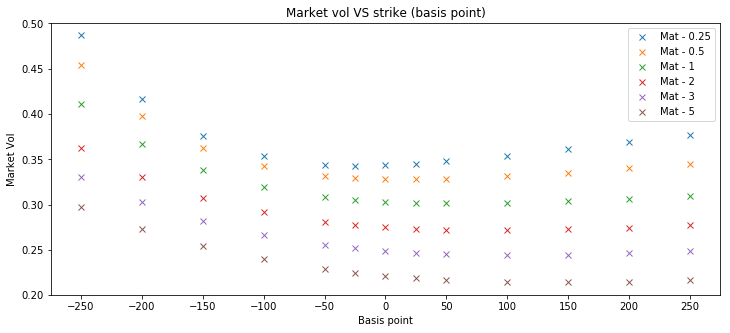

In [18]:
%matplotlib inline
plt.figure(1, figsize=(12,5))
for i in range(len(df_imp.index)):
    plt.plot(bps_raw,df_imp.iloc[i,1:],'x')
    
plt.legend(['Mat - 0.25','Mat - 0.5','Mat - 1', 'Mat - 2','Mat - 3','Mat - 5'],
          loc='best')
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xlabel('Basis point')
plt.ylabel('Market Vol')
plt.title("Market vol VS strike (basis point)")

* The raw data looks good, proceed to calibration

In [19]:
# Calibration of SABR implied normal vol
alpha_cal,rho_cal,sigma0_cal=calibration(initial_guess,beta=0.5,
                                         T=T,K=K,F0=F,MKvol=MKvol,flag=flag)
alpha_cal_ln,rho_cal_ln,sigma0_cal_ln=calibration(initial_guess,beta=0.5,
                                         T=T,K=K,F0=F,MKvol=MKvol,flag='ln')
para_cal=pd.DataFrame(zip(list(alpha_cal),list(rho_cal),list(sigma0_cal),
                         list(alpha_cal_ln),list(rho_cal_ln),list(sigma0_cal_ln)),
                      columns=['Alpha_n','rho_n','sigma0_n','Alpha_ln','rho_ln','sigma0_ln'])
para_cal

,Alpha_n,rho_n,sigma0_n,Alpha_ln,rho_ln,sigma0_ln
0,9.599098,-0.216663,0.755626,0.558514,0.673201,0.066031
1,7.340077,-0.180760,0.635165,0.533979,0.696438,0.063306
2,5.486785,-0.132514,0.511230,0.513821,0.697775,0.059230
3,4.049668,-0.083373,0.398010,0.495756,0.673576,0.054918
4,3.317659,-0.004548,0.326366,0.491079,0.666307,0.050697
5,2.642101,0.091633,0.256727,0.001000,-0.073669,0.048111


In [20]:
# Get the calibrated parameters
for i in range(len(F)):
    print("Calibrated alpha, rho, and sigma0 for maturity ",df_fsr.iloc[i]['Mat yrs'],"is: ",
          '{:.6f}'.format(alpha_cal[i]),'{:.6f}'.format(rho_cal[i]),
          '{:.6f}'.format(sigma0_cal[i]))

Calibrated alpha, rho, and sigma0 for maturity  0.25 is:  9.599098 -0.216663 0.755626
Calibrated alpha, rho, and sigma0 for maturity  0.5 is:  7.340077 -0.180760 0.635165
Calibrated alpha, rho, and sigma0 for maturity  1.0 is:  5.486785 -0.132514 0.511230
Calibrated alpha, rho, and sigma0 for maturity  2.0 is:  4.049668 -0.083373 0.398010
Calibrated alpha, rho, and sigma0 for maturity  3.0 is:  3.317659 -0.004548 0.326366
Calibrated alpha, rho, and sigma0 for maturity  5.0 is:  2.642101 0.091633 0.256727


* Compute SABR implied normal volatility by using calibrated parameters

In [21]:
IMPvol=np.zeros((len(MKvol),len(MKvol.columns)))
for i in range(len(IMPvol)):
    for j in range(len(IMPvol[0])):
        IMPvol[i][j]=SABR_implied_Vol(T[i],K.iloc[i,j],F[i],
                                      sigma0_cal[i],alpha_cal[i],0.5,rho_cal[i],flag)
# Convert matrix to pandas dataframe
IMPvol=pd.DataFrame(IMPvol)

#### Plot the fitted value (SABR implied vol) and market vol

* Fix strike(-250 bp), plot implied vol and market vol VS froward rate

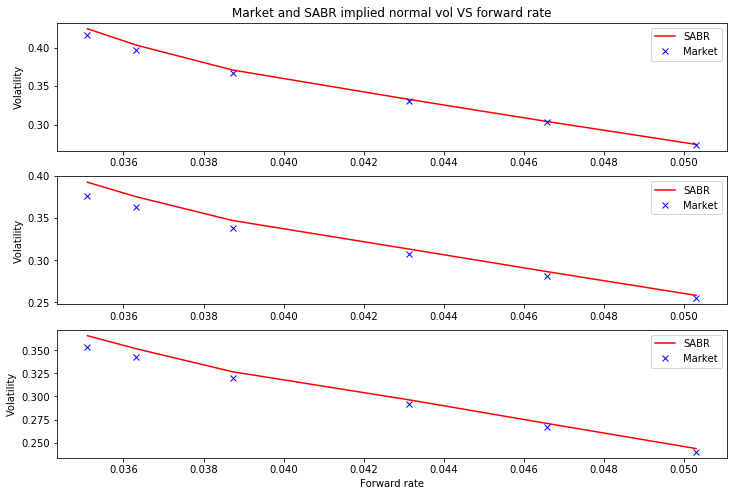

In [22]:
# Plot the market vol and fitted vol VS forward rate
indcol=1  # column index in IMPvol, range(0-10), plot 3 plots once a time
plt.figure(1, figsize=(12,8))

plt.subplot(311)
plt.plot(F,IMPvol.iloc[:,indcol],'r-',F,df_imp.iloc[:,indcol+1],'bx')
plt.legend(['SABR','Market'],loc='best')
#plt.xlabel('Forward rate')
plt.ylabel('Volatility')
plt.title("Market and SABR implied normal vol VS forward rate")

plt.subplot(312)
plt.plot(F,IMPvol.iloc[:,indcol+1],'r-',F,df_imp.iloc[:,indcol+2],'bx')
plt.legend(['SABR','Market'],loc='best')
#plt.xlabel('Forward rate')
plt.ylabel('Volatility')

plt.subplot(313)
plt.plot(F,IMPvol.iloc[:,indcol+2],'r-',F,df_imp.iloc[:,indcol+3],'bx')
plt.legend(['SABR','Market'],loc='best')
plt.xlabel('Forward rate')
plt.ylabel('Volatility')


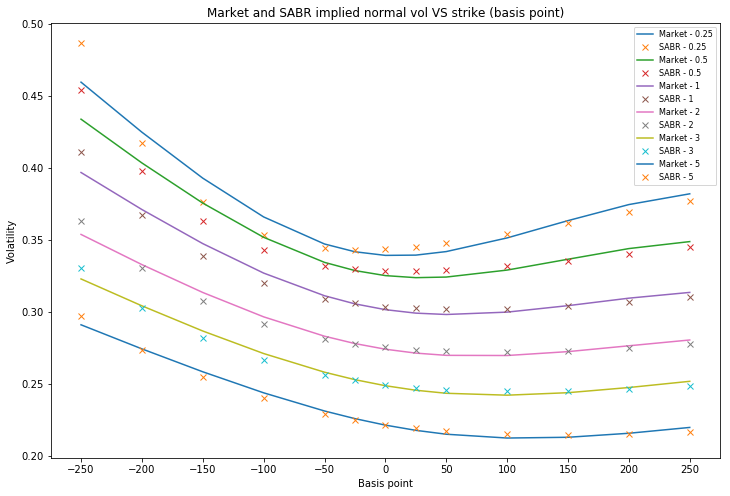

In [23]:
# Plot the market vol and fitted vol VS strike
ind=0 # Row number of maturity, range(0-5)
fig2=plt.figure(1, figsize=(12,8))
for ind in range(len(IMPvol)):
    plt.plot(bps_raw,IMPvol.iloc[ind,:],'-',bps_raw,df_imp.iloc[ind,1:],'x')
plt.legend(['Market - 0.25','SABR - 0.25','Market - 0.5','SABR - 0.5','Market - 1', 'SABR - 1',
            'Market - 2','SABR - 2','Market - 3','SABR - 3','Market - 5','SABR - 5']
           ,loc='upper right',fontsize=8)
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xlabel("Basis point")
plt.ylabel('Volatility')
plt.title("Market and SABR implied normal vol VS strike (basis point)")

### Q5: Generate correlated Gaussian random numbers

* How to do it:
* First assume we have two uncorrelated Gaussian random variables $X$ and $Y$ ($X$, $Y$ ~ $N(0,1)$) and we need them to be correlated with $\rho$.
* By letting $U=X$ and $V=\rho X+\sqrt{1-\rho^2}Y$, we have two new standard normal random variables $U$ and $V$ with correlation $\rho$.
* We can verify that by the following proof: 

Obviously $U$, $V$ are still standard normal r.v.s, we only need to verify their correlation is $\rho$. And,

$$Cov(U,V)=Cov(X,\rho X+\sqrt{1-\rho^2}Y)=\rho Cov(X,X)+0=\rho$$
Thus, $U$ and $V$ are two standard normal random variables with correlation $\rho$.

In [24]:
x=np.random.normal(0,1,10000)
y=np.random.normal(0,1,10000)
rho=0.5 #We presumably set rho equal to 0.5
u=x
v=rho*x+math.sqrt(1-np.power(rho,2))*y

#Now we have two groups of Gaussian random numbers, we verify their correlation is rho(0.5).
np.corrcoef(u,v)

array([[ 1.       ,  0.5045756],
       [ 0.5045756,  1.       ]])

### Q6: Generating MC paths for the SABR model

In [25]:
from numba import jit  #for computational efficiency
@jit
def MC_path(T,F0,sigma0,alpha,beta,rho,numStep):
    '''
    :param T: maturity
    :param F0: current value of the forward
    :param sigma0: initial guess of market vol
    :param alpha, beta, rho: model parameters
    :param numStep: number of steps in discretization
    :return: MC paths of F and sigma
    '''
    delta_t=T/numStep #time step
    u=np.random.normal(0,1,numStep) #generate correlated normal r.v.s
    v=np.random.normal(0,1,numStep)
    x=u
    y=rho*u+math.sqrt(1-np.power(rho,2))*v
    
    F=np.zeros(numStep+1)
    sigma=np.zeros(numStep+1)
    F[0]=F0
    sigma[0]=sigma0
    for i in range(numStep):  #discretization
        F[i+1]=max(F[i]+sigma[i]*np.power(F[i],beta)*math.sqrt(delta_t)*x[i],0)
        sigma[i+1]=sigma[i]*math.exp(alpha*math.sqrt(delta_t)*y[i]-alpha**2*delta_t/2)
    return F,sigma

### Q7: Comparation between two methods

* First we use Monte Carlo method to price options

In [26]:
def MC_SABR_call(T,F0,K,sigma0,alpha,beta,rho,numStep):
    '''
    :param T: maturity
    :param F0: current value of the forward
    :param K: strike
    :param sigma0: initial guess of market vol
    :param alpha, beta, rho: model parameters
    :param numStep: number of steps in discretization
    :return: call price
    '''
    F,sigma=MC_path(T,F0,sigma0,alpha,beta,rho,numStep)
    F_price=F[numStep]
    
    call_price=max(F_price-K,0)

    return call_price

In [27]:
def MC_SABR_put(T,F0,K,sigma0,alpha,beta,rho,numStep):
    '''
    :param T: maturity
    :param F0: current value of the forward
    :param K: strike
    :param sigma0: initial guess of market vol
    :param alpha, beta, rho: model parameters
    :param numStep: number of steps in discretization
    :return: put price
    '''
    F,sigma=MC_path(T,F0,sigma0,alpha,beta,rho,numStep)
    F_price=F[numStep]
    
    put_price=max(-F_price+K,0)

    return put_price

In [28]:
call=np.zeros(10)  #price the call options in Table 1 with MC method
for j in range(5000): #get accumulated price
    call[0]=call[0]+MC_SABR_call(0.25,0.005,0.01,0.0072,1.1,0.2,0.8,10000)
    call[1]=call[1]+MC_SABR_call(0.25,0.05,0.06,0.0224,0.8,0.5,-0.2,10000)
    call[2]=call[2]+MC_SABR_call(0.5,0.01,0.02,0.0400,0.8,0.5,0.7,10000)
    call[3]=call[3]+MC_SABR_call(0.5,0.05,0.06,0.0182,0.7,0.2,-0.3,10000)
    call[4]=call[4]+MC_SABR_call(1,0.015,0.02,0.0232,0.6,0.2,0.4,10000)
    call[5]=call[5]+MC_SABR_call(1,0.04,0.05,0.0500,0.5,0.5,-0.3,10000)
    call[6]=call[6]+MC_SABR_call(2,0.02,0.03,0.0707,0.5,0.5,0.3,10000)
    call[7]=call[7]+MC_SABR_call(2,0.06,0.07,0.0176,0.5,0.2,-0.1,10000)
    call[8]=call[8]+MC_SABR_call(5,0.05,0.06,0.0146,0.4,0.2,0.2,10000)
    call[9]=call[9]+MC_SABR_call(5,0.05,0.07,0.0447,0.3,0.5,-0.5,10000)
for i in range(10): 
    call[i]=call[i]/5000   #get the mean of accumulated price
    print(call[i])

1.13578037542e-05
2.16415827075e-07
6.87423222207e-05
0.000251738462889
0.00225904791738
0.000906538222416
0.00298131422801
0.00235722170776
0.00418527190815
0.00212962300185


In [29]:
put=np.zeros(10) #price the put options in Table 1 with MC method
for j in range(5000):  #get accumulated price
    put[0]=put[0]+MC_SABR_put(0.25,0.005,0.002,0.0354,0.9,0.5,0.8,10000)
    put[1]=put[1]+MC_SABR_put(0.25,0.04,0.02,0.0095,0.2,0.2,-0.0,10000)
    put[2]=put[2]+MC_SABR_put(0.5,0.01,0.005,0.0400,0.7,0.5,0.4,10000)
    put[3]=put[3]+MC_SABR_put(0.5,0.03,0.02,0.0577,0.6,0.5,-0.2,10000)
    put[4]=put[4]+MC_SABR_put(1,0.03,0.01,0.0202,0.6,0.2,0.5,10000)
    put[5]=put[5]+MC_SABR_put(1,0.05,0.04,0.0182,0.6,0.2,-0.5,10000)
    put[6]=put[6]+MC_SABR_put(2,0.04,0.025,0.0500,0.5,0.5,0.2,10000)
    put[7]=put[7]+MC_SABR_put(2,0.05,0.035,0.0447,0.5,0.5,-0.1,10000)
    put[8]=put[8]+MC_SABR_put(5,0.05,0.035,0.0146,0.4,0.2,0.1,10000)
    put[9]=put[9]+MC_SABR_put(5,0.06,0.04,0.0176,0.4,0.2,0.0,10000)
for i in range(10):
    put[i]=put[i]/5000  #get the mean of accumulated price
    print(put[i])

0.0
0.0
1.14029561075e-05
0.00030314535813
4.20292595184e-05
0.00122342320295
0.000867794780304
0.00122941512069
0.00239386436282
0.00292707609499


* Next, we compute the SABR implied volatility for Normal model and then price the options with Normal model

In [30]:
def price_normal_call(T,F0,K,sigma0,alpha,beta,rho):
    '''
    :param T: maturity
    :param F0: current value of the forward
    :param K: strike
    :param sigma0: initial guess of market vol
    :param alpha, beta, rho: model parameters
    :param numStep: number of steps in discretization
    :return: put price
    '''
    #Compute Zeta by formula (15) in lecture notes 4 and then D_zeta
    zeta=alpha/sigma0/(1-beta)*(F0**(1-beta)-K**(1-beta))
    D_zeta=math.log((math.sqrt(1-2*rho*zeta+zeta**2)+zeta-rho)/(1-rho))
    #Compute implied normal volatility in the case of normal SABR model
    vol=alpha*(F0-K)/D_zeta
    #price the call option with Normal model
    disc=1
    d1=(F0-K)/(vol*math.sqrt(T))
    d2=-d1
    call_price=disc*vol*math.sqrt(T)*(d1*norm.cdf(d1)+
                                                    math.exp(-0.5*d1*d1)/math.sqrt(2*np.pi))
    return call_price

In [31]:
call_normal=np.zeros(10)
call_normal[0]=price_normal_call(0.25,0.005,0.01,0.0072,1.1,0.2,0.8)
call_normal[1]=price_normal_call(0.25,0.05,0.06,0.0224,0.8,0.5,-0.2)
call_normal[2]=price_normal_call(0.5,0.01,0.02,0.0400,0.8,0.5,0.7)
call_normal[3]=price_normal_call(0.5,0.05,0.06,0.0182,0.7,0.2,-0.3)
call_normal[4]=price_normal_call(1,0.015,0.02,0.0232,0.6,0.2,0.4)
call_normal[5]=price_normal_call(1,0.04,0.05,0.0500,0.5,0.5,-0.3)
call_normal[6]=price_normal_call(2,0.02,0.03,0.0707,0.5,0.5,0.3)
call_normal[7]=price_normal_call(2,0.06,0.07,0.0176,0.5,0.2,-0.1)
call_normal[8]=price_normal_call(5,0.05,0.06,0.0146,0.4,0.2,0.2)
call_normal[9]=price_normal_call(5,0.05,0.07,0.0447,0.3,0.5,-0.5)

for i in range(10):
    print(call_normal[i])

1.48852015304e-05
4.17083996541e-07
6.96554792992e-05
0.000243898007978
0.00233951944152
0.000888178928002
0.00297764024029
0.00214544994626
0.00386610998723
0.00220100669614


In [32]:
def price_normal_put(T,F0,K,sigma0,alpha,beta,rho):
    '''
    :param T: maturity
    :param F0: current value of the forward
    :param K: strike
    :param sigma0: initial guess of market vol
    :param alpha, beta, rho: model parameters
    :param numStep: number of steps in discretization
    :return: put price
    '''
    #Compute Zeta by formula (15) in lecture notes 4 and then D_zeta
    zeta=alpha/sigma0/(1-beta)*(F0**(1-beta)-K**(1-beta))
    D_zeta=math.log((math.sqrt(1-2*rho*zeta+zeta**2)+zeta-rho)/(1-rho))
    #Compute implied normal volatility in the case of normal SABR model
    vol=alpha*(F0-K)/D_zeta
    #price the put option with Normal model
    disc=1
    d1=(F0-K)/(vol*math.sqrt(T))
    d2=-d1
    put_price=disc*vol*math.sqrt(T)*(d2*norm.cdf(d2)+
                                                   math.exp(-0.5*d2*d2)/math.sqrt(2*np.pi))
    return put_price

In [33]:
put_normal=np.zeros(10)
put_normal[0]=price_normal_put(0.25,0.005,0.002,0.0354,0.9,0.5,0.8)
put_normal[1]=price_normal_put(0.25,0.04,0.02,0.0095,0.2,0.2,-0.0)
put_normal[2]=price_normal_put(0.5,0.01,0.005,0.0400,0.7,0.5,0.4)
put_normal[3]=price_normal_put(0.5,0.03,0.02,0.0577,0.6,0.5,-0.2)
put_normal[4]=price_normal_put(1,0.03,0.01,0.0202,0.6,0.2,0.5)
put_normal[5]=price_normal_put(1,0.05,0.04,0.0182,0.6,0.2,-0.5)
put_normal[6]=price_normal_put(2,0.04,0.025,0.0500,0.5,0.5,0.2)
put_normal[7]=price_normal_put(2,0.05,0.035,0.0447,0.5,0.5,-0.1)
put_normal[8]=price_normal_put(5,0.05,0.035,0.0146,0.4,0.2,0.1)
put_normal[9]=price_normal_put(5,0.06,0.04,0.0176,0.4,0.2,0.0)

for i in range(10):
    print(put_normal[i])

2.19402644673e-09
1.67821316574e-18
1.33181551527e-05
0.000268661029597
3.06109286885e-05
0.00122969518057
0.000805055310936
0.00116326911866
0.00211645581339
0.00263279561313


* In the end, we compare the results given by two different methods.

In [34]:
%matplotlib inline

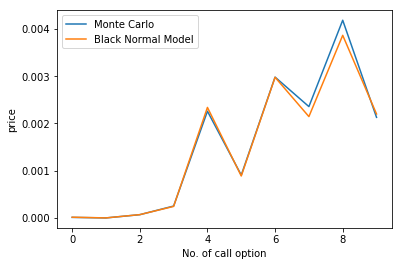

In [35]:
plt.plot(call)
plt.plot(call_normal)
plt.xlabel('No. of call option')
plt.ylabel('price')
plt.legend(['Monte Carlo','Black Normal Model'],loc='best')

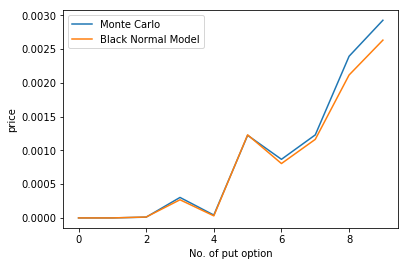

In [36]:
plt.plot(put)
plt.plot(put_normal)
plt.xlabel('No. of put option')
plt.ylabel('price')
plt.legend(['Monte Carlo','Black Normal Model'],loc='best')

* From the graphs, we find the prices of options given by Monte Carlo method and Black Formula are quite matched.